# Problem Set 3, due May 2 at 11:59am (i.e., noon).

### Before You Start

Make sure the following libraries load correctly (hit Ctrl-Enter). Note that while you are loading several powerful libraries, including machine learning libraries, the goal of this problem set is to implement several algorithms from scratch. In particular, you should *not* be using any built-in libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! Part 1 will be relatively easy; Part 2 will take more time.

*Also note:* For this assignment we are requiring you to use base **matplotlib** - not Seaborn or other packages. This will help you become familiar with techniques for maintaining fine-grained control over your data visualizations. It will also help our graders, who spent countless hours trying to make various versions import for grading.

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

---

## Introduction to the assignment

For this assignment, you will be using the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing).  Please read about the dataset carefully before continuing.  Use the following commands to load the dataset:


In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()

---

## Part 1: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for an instance in the data.
Before beginning the "real" work, refamiliarize yourself with the dataset.

(array([  21.,   55.,   82.,  154.,   84.,   41.,   30.,    8.,   10.,   21.]),
 array([  5. ,   9.5,  14. ,  18.5,  23. ,  27.5,  32. ,  36.5,  41. ,
         45.5,  50. ]),
 <a list of 10 Patch objects>)

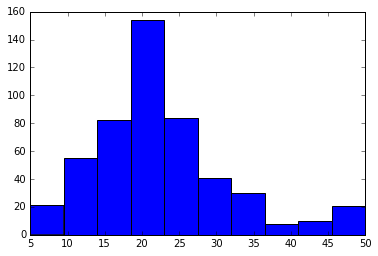

In [3]:
# prepare IPython to work with matplotlib and import the library to something convenient
%matplotlib inline  
import matplotlib.pyplot as plt  

# edit the code below to make the graph look good
plt.hist(bdata.target)

### 1.1: Scatter plot of housing prices and crime

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional. No excuses if you don't get it right this time around!


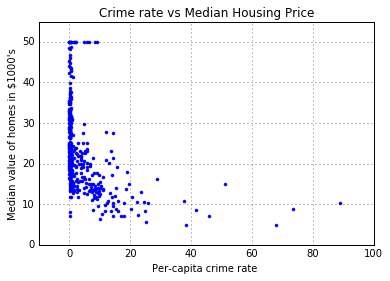

In [4]:
ax = plt.gca()
ax.plot(bdata.data[:,0], bdata.target , '.')
ax.axis([0, 100, 0, 55])
ax.set_ylabel("Median value of homes in $1000's")
ax.set_xlabel("Per-capita crime rate ")
ax.set_title("Crime rate vs Median Housing Price")
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.set_xlim(-10,100)
ax.grid(True) # Add grid by setting to True
plt.show()

### 1.2 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation)



In [5]:
from __future__ import division
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print compute_rmse((2,2,3),(0,2,6)
2.16
"""
def compute_rmse(predictions, yvalues):
    count = 0
    sums = 0
    rmse = 0
    for each in predictions:
        sums += (predictions[count] - yvalues[count]) ** 2
        count += 1
    rmse = np.sqrt(sums / len(predictions))
    return round(rmse, 4)

print compute_rmse((2,2,3),(0,2,6))

2.0817


### 1.3 Divide your data into training and testing datasets

Randomly select 66% of the data and put this in a training dataset (call this "bdata_train"), and place the remaining 34% in a testing dataset (call this "bdata_test")


In [6]:
import random
boston = pd.DataFrame(bdata.data)
boston.columns = bdata.feature_names[:]
boston['MEDV'] = bdata.target

# dataFrame with values that might be used
table = pd.DataFrame()
table['RM'] = boston['RM']
table['CRIM'] = boston['CRIM']
table['MEDV'] = boston['MEDV']
table['LSTAT'] = boston['LSTAT']
table['NOX'] = boston['NOX']
table['ZN'] = boston['ZN']
table['AGE'] = boston['AGE']
table['TAX'] = boston['TAX']
table['DIS'] = boston['DIS']


table.sort_values(by='CRIM', ascending=False).head(10)

#randomly sort the rows in the table.
table.reindex(np.random.permutation(table.index))

#take the first 66% of the rows in the table
bdata_train = table[:int(len(table)*0.66)]

#take the remaning 34%
bdata_test = table[len(bdata_train):]

#make the indices in the test data start at 0 
bdata_test.index = np.arange(0, len(bdata_test))


### 1.4 Use a very bad baseline for prediction, and compute RMSE

Create a model that predicts, for every observation x_i, that the median home value is the average (mean) of the median values for all instances in the training set.  Compute the RMSE on the training set.  Now compute the RMSE on the test data set (but use the model you trained on the training set!).  How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?

In [7]:
#RMSE for training set
means = [np.mean(bdata_train['MEDV'])] * len(bdata_train)                 
print compute_rmse(means, bdata_train['MEDV'])

test = []
for each in bdata_test['MEDV']:
    test.append(each)
    
#RMSE for test set
means = [np.mean(test)] * len(test)
print compute_rmse(means, test)

### RMSE for Train is 8.5
### RMSE  for Test is 8.01

8.5841
8.0133


The RMSE was higher for the training set. I would asume that the testing set would have a higher RMSE becasue there is less data for it to even out. But maybe the testing set just happened to get some numbers that were closer together in distance. 

---

## Part 2: Nearest Neighbors


### 2.1 Nearest Neighbors: Distance function
Let's try and build a machine learning algorithm to beat the "Average Value" baseline that you computed above.  Soon you will implement the Nearest Neighbor algorithm, but first you need to create a distance metric to measure the distance (and similarity) between two instances.  Write a generic function to compute the L-Norm distance (called the [*p*-norm](http://en.wikipedia.org/wiki/Norm_(mathematics) distance on Wikipedia). Verify that your function works by computing the Euclidean distance between the points (3,4) and (6,8).

In [8]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print distance((3,4),(6,8),2)
5.0

"""
x1 = [3,4]
x2 = [6,8]
L = 2
def distance(x1, x2, L):
    count = 0
    dist = 0

    for i in x1:
        dist += abs(x1[count] - x2[count]) ** L
        count += 1
    return dist ** (1 / L)

print distance(x1,x2,L)

### Distance = 5.0

5.0


### 2.2 Basic Nearest Neighbor algorithm

Now things get fun.  Your task is to implement a basic nearest neighbor algorithm from scratch.  Your simple model will use two input features (CRIM and RM) and a single output (MEDV).  In other words, you are modelling the relationship between median home value and crime rates and house size.

Use your training data (bdata_train) to "fit" your model, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts, for each instance in the testing data (bdata_test), the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the MEDV value of the closest training instance.  Have your function take L as an input, where L is passed to the distance function.

Compute the RMSE for the Nearest Neighbor predictions on the test set, using the Euclidean distance.  Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.

In [9]:
"""
Function
--------
nneighbor

Given a traning set and testing set as well as features to use and L-distance will find nerest neighbor for each point

Parameters
----------
bdata_train, bdata_test : dataFrame
    dataFrame with features and data fro them

L: int
    Value of L to use in computing distances

Returns
-------
features : array
   array of features to use from dataFrame
   
L: int
    L is used in the distance function

Example
-------
>>> print nneighbor(bdata_train,bdata_test,features,2)
Time taken: 1.14 seconds
8.1575

"""
import time
def nneighbor(bdata_train,bdata_test,features,L):
    start_time = time.time()
    predictions = []
    countTest = 0
    countTrain = 0
    for each in bdata_test['MEDV']:
        dist = []
        x1 = []
        x2 = []
        smallest = []
        
        for each in features:
            x2.append(bdata_test[each][countTest])
            
        while countTrain < 333:
            for each in features:
                x1.append(bdata_train[each][countTrain])
            dist.append(distance(x1,x2,L))
            x1 = []
            countTrain += 1 
            
        predictions.append(bdata_train['MEDV'][dist.index(min(dist))])
        countTest += 1
        x2 = [] 
        smallest = 0
        dist = []
        countTrain = 0
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return  compute_rmse(predictions, bdata_test['MEDV'])
features = ['CRIM','RM']
print nneighbor(bdata_train,bdata_test,features,2)

### RMSE is 8.157

Time taken: 1.22 seconds
8.1575


### 2.3 Results and Normalization

If you were being astute, you would have noticed that we never normalized our features -- a big no-no with Nearest Neighbor algorithms.  Write a generic normalization function that takes as input an array of values for a given feature, and returns the normalized array (subtract the mean and divide by the standard deviation).

Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations.

*NOTE*: To normalize properly, best practice is to compute the mean and standard deviation on the training set, and use these values to normalize the testing dataset. However, for this problem set, it is okay if you separately normalize each dataset using the respective mean and standard deviation.

In [10]:
"""
function
-------
normalize
    givin data it will normalize it
--------
paramater
    RAW_DATA
    data to be normalized
-----
returns
    normalized data array
"""
def normalize(raw_data):
    normalized_data = []
    for each in raw_data:
        normalized_data.append((each - np.mean(raw_data)) / np.std(raw_data))
    
    return normalized_data

# normalizing all features we want to use
bdata_train.loc[:,'MEDV'] = normalize(bdata_train['MEDV'])
bdata_train.loc[:,'CRIM'] = normalize(bdata_train['CRIM'])
bdata_train.loc[:,'RM'] = normalize(bdata_train['RM'])
bdata_test.loc[:,'MEDV'] = normalize(bdata_test['MEDV'])
bdata_test.loc[:,'CRIM'] = normalize(bdata_test['CRIM'])
bdata_test.loc[:,'RM'] = normalize(bdata_test['RM'])

bdata_train.loc[:,'LSTAT'] = normalize(bdata_train['LSTAT'])
bdata_train.loc[:,'NOX'] = normalize(bdata_train['NOX'])
bdata_test.loc[:,'LSTAT'] = normalize(bdata_test['LSTAT'])
bdata_test.loc[:,'NOX'] = normalize(bdata_test['NOX'])

bdata_train.loc[:,'ZN'] = normalize(bdata_train['ZN'])
bdata_train.loc[:,'AGE'] = normalize(bdata_train['AGE'])
bdata_test.loc[:,'ZN'] = normalize(bdata_test['ZN'])
bdata_test.loc[:,'AGE'] = normalize(bdata_test['AGE'])

bdata_train.loc[:,'DIS'] = normalize(bdata_train['DIS'])
bdata_train.loc[:,'TAX'] = normalize(bdata_train['TAX'])
bdata_test.loc[:,'DIS'] = normalize(bdata_test['DIS'])
bdata_test.loc[:,'TAX'] = normalize(bdata_test['TAX'])

# re-run after normalization
print nneighbor(bdata_train,bdata_test,features,2)

### RMSE is 1.05

Time taken: 1.1 seconds
1.1247


C:\Users\ermmc\Anaconda2\lib\site-packages\pandas\core\indexing.py:508: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Once the data is normalized the RMSE drops from over 8 to just about 1

### 2.4 Optimization

A lot of the decisions we've made so far have been arbitrary.  Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L!

What combination of features and distance function provide the lowest RMSE?  Do your decisions affect the running time of the algorithm?

In [11]:
# features are the variables to be used next time nneighbor is used
features = ['CRIM','RM']
print 'original: ' + str(nneighbor(bdata_train,bdata_test,features,2))
print ''
print 'original with L of 3: ' + str(nneighbor(bdata_train,bdata_test,features,3))
print ''

features = ['LSTAT','NOX']
print 'New features: ' + str( nneighbor(bdata_train,bdata_test,features,2))
print ''
print 'New features with L of 3: ' + str( nneighbor(bdata_train,bdata_test,features,3))
print ''

features = ['CRIM','RM','LSTAT','NOX']
print 'old and new features: ' + str(nneighbor(bdata_train,bdata_test,features,2))
print ''
print 'old and new features with L of 3: ' + str(nneighbor(bdata_train,bdata_test,features,3))

Time taken: 1.11 seconds
original: 1.1247

Time taken: 1.05 seconds
original with L of 3: 1.1324

Time taken: 1.1 seconds
New features: 1.0015

Time taken: 1.09 seconds
New features with L of 3: 1.0037

Time taken: 2.14 seconds
old and new features: 0.9468

Time taken: 2.16 seconds
old and new features with L of 3: 0.9346


changing the featurns made it better, but it was even better when the features were added to the original ones and the L distance was changed to 3!

### 2.5 Cross-Validation

The more you tinkered with your features and distance function, the higher the risk that you overfit your training data.  To prevent this sort of overfitting, you need to use cross-validation (see K-fold [cross-validation](http://en.wikipedia.org/wiki/Cross-validation_(statistics)).  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function you write here will be used several more times in this problem set, so do your best to write efficient code! (Note that the sklearn package has a built-in [K-fold](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.)

Use 10-fold cross-validation and report the average RMSE for Nearest Neighbors using Euclidean distance with CRIM and RM input features, as well as the total running time for the full run of 10 folds.  In other words, randomly divide your dataset into 10 equally-sized samples, and for each of 10 iterations (the "folds"), use 9 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for testing.  Compute the RMSE of that particular test set, then move on to the next iteration.  Report the average RMSE across the 10 iterations.

In [12]:
import random
features = ['CRIM','RM']
table.reindex(np.random.permutation(table.index))
test = table[:int(len(table)*0.1)]
train = table[len(test):]
train.index = np.arange(0, len(train))


def kcross(train,test,K,L,cross_val):
    start_time = time.time()
    split = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]

    avgRMSE = 0
    
    for each in split(train,int(len(train )/ 9)):
        if cross_val:
            avgRMSE += knn(train,test,features,K,L)
        else:
             avgRMSE += nneighbor(train,test,features,L)
    print "Time taken for 10 folds: " + str(round(time.time() - start_time,2)) + " seconds"   
    return (avgRMSE / 9)

kcross(train,test,3,2,False)

#NOTE: cross_val is to determine which nearest neighbors algorithim we are using. The one that takes in K or not

### RMSE is 0.6491

Time taken: 0.36 seconds
Time taken: 0.3 seconds
Time taken: 0.32 seconds
Time taken: 0.32 seconds
Time taken: 0.31 seconds
Time taken: 0.31 seconds
Time taken: 0.33 seconds
Time taken: 0.32 seconds
Time taken: 0.38 seconds
Time taken: 0.3 seconds
Time taken for 10 folds: 3.28 seconds


0.6491111111111112

### 2.6 K-Nearest Neighbors Algorithm

Implement the K-Nearest Neighbors algorithm.  Using 10-fold cross validation, report the RMSE for K=3 and the running time of the algorithm.

In [ ]:
"""
Function
--------
knn

Given a normalized traning set and testing set as well as features to use and K and L-distance will find nerest neighbor for each point
with k-Cross validation

Parameters
----------
bdata_train, bdata_test : dataFrame
    dataFrame with features and data from them

L: int
    Value of L to use in computing distances
K: int 
    number of nearest neighbors we find

Returns
-------
RMSE: float
    root mean squared error for knn

Example
-------
>>> print nneighbor(bdata_train,bdata_test,features,3,2)
Time taken: 1.14 seconds
1.02

"""

def smallDist(k,dist):
    
    count = 0
    smallest = []
    while count < k:
        smallest.append(dist.index(min(dist)))
        dist[dist.index(min(dist))] = 10000000
        count += 1
    return smallest

def knn(bdata_train,bdata_test,features,K, L):
    
    predictions = []
    countTest = 0
    countTrain = 0
    for each in bdata_test['MEDV']:
        dist = []
        x1 = []
        x2 = []
        smallest = []
        for each in features:
            x2.append(bdata_test[each][countTest])

        while countTrain < 333:
            for each in features:
                x1.append(bdata_train[each][countTrain])

            dist.append(distance(x1,x2,L))
            x1 = []
            countTrain += 1 
        
        smallest = smallDist(K,dist)
        avgMEDV = 0
        
        for each in smallest:
            avgMEDV += bdata_train['MEDV'][each]
        predictions.append(avgMEDV / len(smallest))
        x2 = []  
        countTest += 1
        smallest = 0
        dist = []
        countTrain = 0
    
    return  compute_rmse(predictions, bdata_test['MEDV'])


features = ['CRIM','RM']

print kcross(train,test,3,2,True)

### RMSE is 0.6116

Time taken for 10 folds: 3.58 seconds
0.611666666667


### 2.7 Using cross validation to find K

What is the best choice of K?  Compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.  Use the following features in your model, and don't forget to normalize: CRIM, ZN, RM, AGE, DIS, TAX.  Create a graph that shows how RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

In [ ]:
features = ['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'TAX']
count = 1
rmse = []
while count <= 25:
    rmse.append(kcross(train,test,count,2,True))
    count += 1

Time taken for 10 folds: 8.95 seconds
Time taken for 10 folds: 8.65 seconds
Time taken for 10 folds: 8.67 seconds
Time taken for 10 folds: 8.67 seconds
Time taken for 10 folds: 8.67 seconds
Time taken for 10 folds: 8.63 seconds
Time taken for 10 folds: 8.78 seconds
Time taken for 10 folds: 8.75 seconds
Time taken for 10 folds: 8.64 seconds
Time taken for 10 folds: 8.9 seconds

In [ ]:

ax = plt.gca()
ax.plot(range(0,25),rmse)

ax.set_ylabel("RMSE after cross-fold")
ax.set_xlabel("K-folds")
ax.set_title("RMSE vs K value")
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.set_xlim(-5,30)
ax.grid(True) # Add grid by setting to True
plt.show()

It is interesting that RMSE goes down, then up, then down agian then shoots back up. I would think there would only be one dip down as K goes up. However the optimal value for K is 3. 

### Extra-Credit: Forward selection

Thus far the choice of predictor variables has been rather arbitrary. For extra credit, implement a basic [forward selection](http://www.stat.ubc.ca/~rollin/teach/643w04/lec/node41.html) algorithm to progressively include features that decrease the cross-validated RMSE of the model. Note that the optimal value of K may be different for each model, so you may want to use cross-validation to choose K each time (but it is also fine if you fix K at the optimal value from 2.7).  Create a graph that shows RMSE as a function of the number of features in the model. Label each point on the x-axis with the name of the feature that is added at that step in the forward selection algorithm. *(For instance, if the optimal single-feature model has CRIM with RMSE = 10, and the optimal two-feature model has CRIM+ZN with RMSE=9, the first x-axis label will say CRIM and the second x-axis lable with say ZN)*